In [1]:
import matplotlib.pyplot as plt
import itertools
import h5py
import pandas as pd
import numpy as np

## 1. Loading Data

In [2]:
# For use in train_test_split and other randomized functions.
random_state_seed = 42

# Read from HDF5 file, ignoring the time column (first column) and converting the labels to (jumping)/(not walking).
with h5py.File('sensor_data.hdf5', 'r') as f:
    train_data = pd.DataFrame.from_records(
        ((1 if n.split('_')[1] == 'jumping' else 0, pd.DataFrame(d[:, 1:]))
            for n, d in f['dataset/Train'].items()), columns=['label', 'interval'])
    test_data = pd.DataFrame.from_records(
        ((1 if n.split('_')[1] == 'jumping' else 0, pd.DataFrame(d[:, 1:]))
            for n, d, in f['dataset/Test'].items()), columns=['label', 'interval'])


In [3]:
print(train_data.shape)
print(test_data.shape)
# Different shapes since the two devices have different sampling rates.
print(train_data.iloc[0, 1].shape)
print(train_data.iloc[36460, 1].shape)

(107717, 2)
(11969, 2)
(501, 4)
(1055, 4)


## 3. Visualization

In [4]:
def plot_interval(interval, label):
    _, ax = plt.subplots(figsize=(10, 10))

    ax.plot(interval[0], c='blue', label='x_acc')
    ax.plot(interval[1], c='orange', label='y_acc')
    ax.plot(interval[2], c='red', label='z_acc')

    ax.set_title(f'Acceleration Data for interval of class {label}')
    ax.set_xlabel('time steps')
    ax.set_ylabel('acceleration (m/s)')
    plt.show()

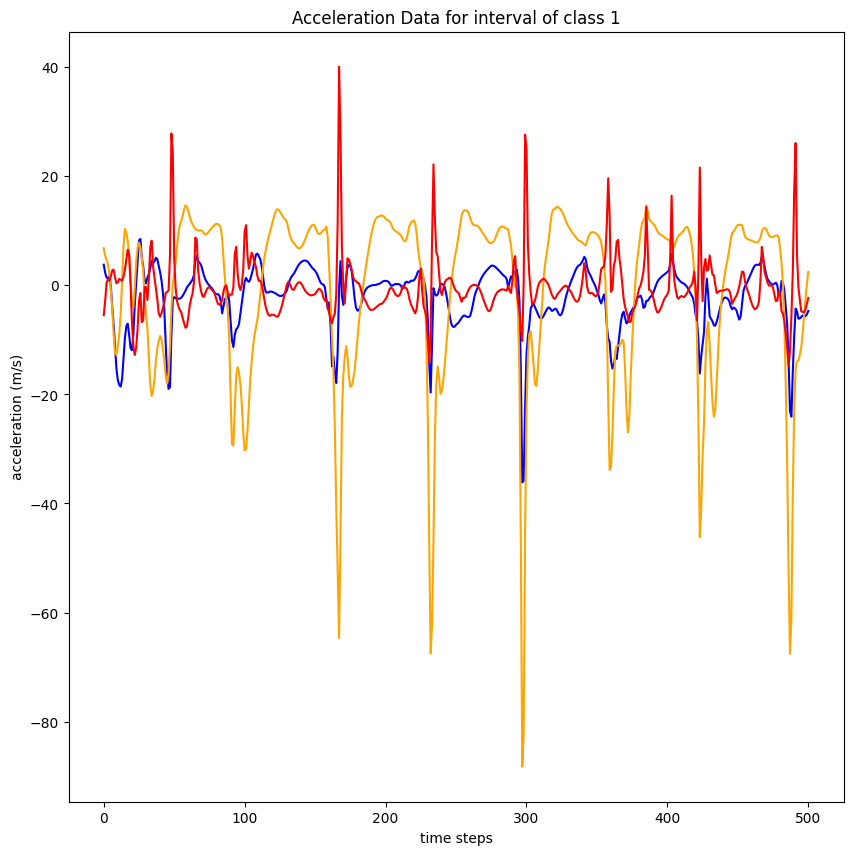

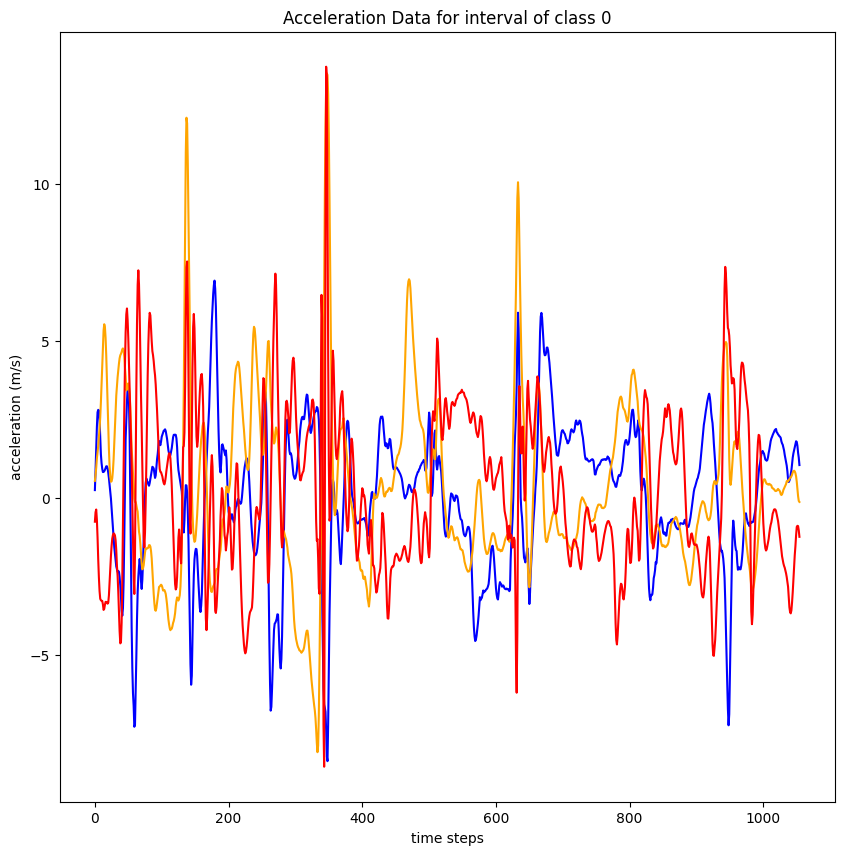

In [5]:
plot_interval(train_data.iloc[0, 1], train_data.iloc[0, 0])
plot_interval(train_data.iloc[36460, 1], train_data.iloc[36460, 0])

## 4. Pre-processing

In [12]:

# 4. Pre-processing
# Apply 10 SMA to both training and testing data intervals. Using a small window size since we don't want to lose the shape of the data.
train_data['interval_ma'] = train_data['interval'].apply(lambda x: x.rolling(window=10).mean())
test_data['interval_ma'] = test_data['interval'].apply(lambda x: x.rolling(window=10).mean())

# Normalization will be applied to extracted features.
# Will not be removing outliers.

In [13]:
print(train_data)

        label                                           interval  \
0           1              0         1         2          3
0...   
1           0               0         1         2         3
0...   
2           0               0         1          2          3...   
3           0              0         1         2         3
0 ...   
4           1               0          1          2          ...   
...       ...                                                ...   
107712      0              0         1         2         3
0 ...   
107713      1                0          1          2         ...   
107714      1                0         1         2          3...   
107715      1               0         1         2          3
...   
107716      0              0         1         2          3
0...   

                                              interval_ma  
0                    0          1         2          3...  
1                    0         1         2         3
0...  
2  

In [14]:
print(type(train_data.iloc[2222, 1]))
print(train_data.iloc[2222, 1])
print(train_data.iloc[2222, 1].shape)

<class 'pandas.core.frame.DataFrame'>
            0         1         2         3
0   -0.880796 -3.667995 -0.195196  3.777313
1   -0.959639 -2.980941 -0.571160  3.183259
2   -1.107942 -2.091102 -0.840821  2.511419
3   -1.242996 -0.838057 -1.052494  1.831699
4   -1.373058  0.569329 -1.233502  1.931567
..        ...       ...       ...       ...
496 -1.844121 -4.792628  1.807818  5.444104
497 -2.197717 -4.934497  1.725276  5.670608
498 -2.469112 -4.996067  1.557887  5.786554
499 -2.676373 -5.184913  1.417198  6.004561
500 -2.711666 -5.411647  1.235388  6.177802

[501 rows x 4 columns]
(501, 4)


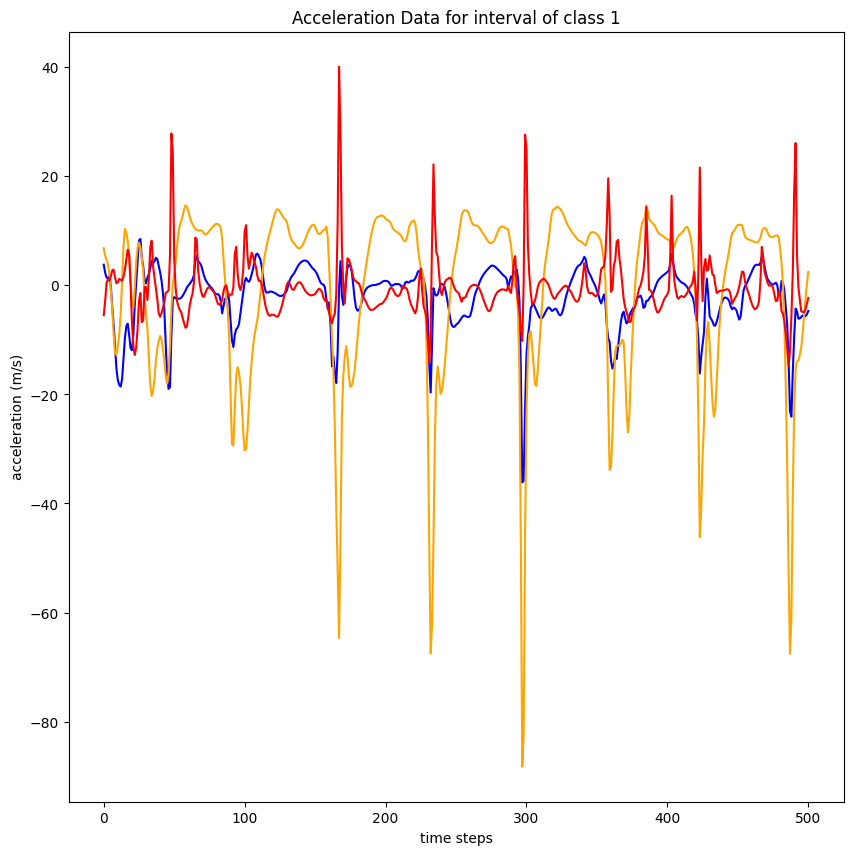

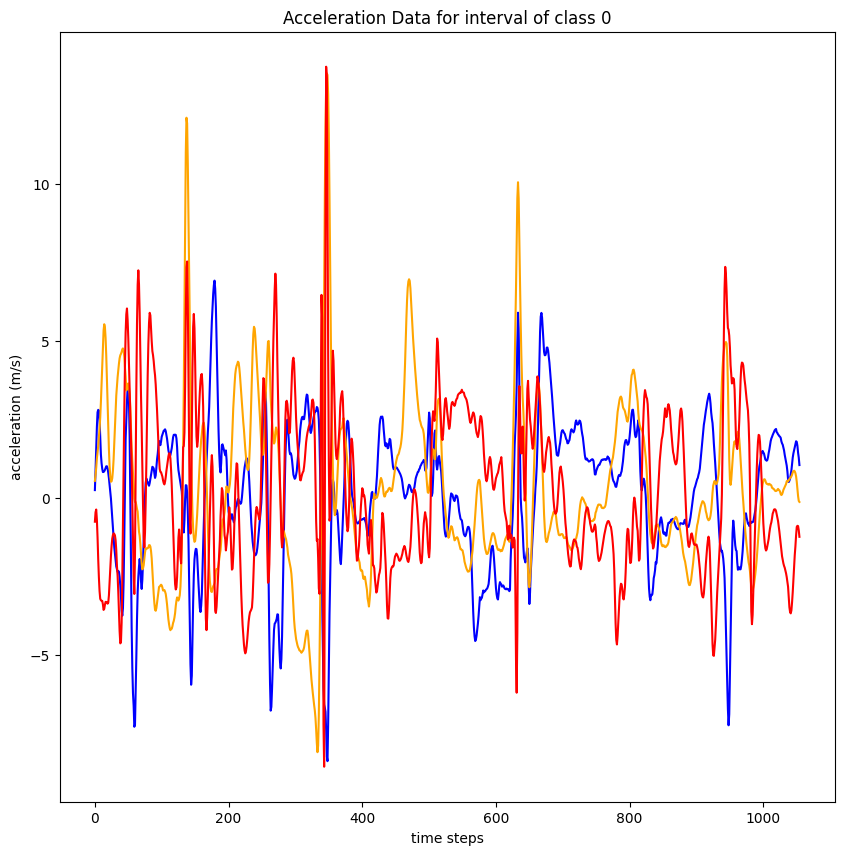

In [15]:
plot_interval(train_data.iloc[0, 1], train_data.iloc[0, 0])
plot_interval(train_data.iloc[36460, 1], train_data.iloc[36460, 0])

## 5. Feature Extraction & Normalization

In [16]:
def feature_extract(intervals: pd.Series) -> pd.DataFrame:
# range is calculated by doing c.max() - c.min()
    return pd.DataFrame.from_records(intervals.apply(lambda c: pd.DataFrame([c.max(), c.min(), c.max() - c.min(), c.mean(), c.median(), c.std(), c.var()]).to_numpy().flatten()))

In [17]:
# 5. Feature extraction & Normalization
train_features = feature_extract(train_data['interval_ma'])
test_featuers = feature_extract(test_data['interval_ma'])

In [18]:
print(train_features)

               0          1          2           3          4          5   \
0        8.503110  14.639033  40.075478   95.923567 -36.144012 -88.263786   
1       30.541613  13.346476  20.726767   31.785883 -17.704426  -8.009818   
2        6.755989  13.346476  20.726767   25.234554 -17.704426  -7.590126   
3        4.799695   2.489998   6.351387    6.991157  -1.943872  -2.130958   
4       31.622442  70.341248  57.620758   99.717121 -19.208342 -22.169598   
...           ...        ...        ...         ...        ...        ...   
107712   4.845971   2.055248   6.421830    7.104499  -2.104054  -2.402503   
107713  31.622442  70.341248  57.620758   99.717121 -19.208342 -22.169598   
107714  55.408104  74.295250  73.708618  125.790996 -73.118088 -69.889435   
107715  32.510441  35.261955  72.415436   85.364489 -44.515511 -15.781944   
107716   4.152100   7.099126   9.707619   11.446886  -4.698325  -6.516329   

               6         7           8           9   ...        18         

In [19]:
# Remove rows with NaN values.
train_features_labels = pd.concat([train_features, train_data['label']], axis=1).dropna()
test_featuers_labels = pd.concat([test_featuers, test_data['label']], axis=1).dropna()

In [20]:
print(train_features_labels.shape)
print(test_featuers_labels.shape)

(107704, 29)
(11966, 29)


In [21]:
# Apply MinMaxScaler to prevent features with larger scales from disproportionately influencing the results.
# MinMaxScaler is chosed as opposed to StandardScaler since the data is not expected to be normally distributed.

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(train_features_labels.iloc[:, :-1])
# X_test = scaler.transform(test_features_labels.iloc[:, :-1])
# The above code is commented out because the data is being normalized with the pipeline.
X_train = train_features_labels.iloc[:, :-1]
X_test = test_featuers_labels.iloc[:, :-1]
Y_train = train_features_labels['label']
Y_test = test_featuers_labels['label']

In [22]:
print(X_train.shape, type(X_train))
print(X_test.shape, type(X_test))
print(Y_train.shape, type(Y_train))
print(Y_test.shape, type(Y_test))

(107704, 28) <class 'pandas.core.frame.DataFrame'>
(11966, 28) <class 'pandas.core.frame.DataFrame'>
(107704,) <class 'pandas.core.series.Series'>
(11966,) <class 'pandas.core.series.Series'>


## 6. Creating a Classifier

In [23]:
# 6. Creating a Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

classifier_std = make_pipeline(StandardScaler(), LogisticRegression(random_state=random_state_seed, max_iter=1000))
classifier_minmax = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=random_state_seed, max_iter=1000))

In [24]:
classifier_std.fit(X_train, Y_train)
classifier_minmax.fit(X_train, Y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [27]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, roc_curve

# Testing. 
Y_pred = classifier_minmax.predict(X_test)
Y_pred_proba = classifier_minmax.predict_proba(X_test)

In [1]:
# Model Accuracy.
print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'Recall: {recall_score(Y_test, Y_pred)}')
# Confusion Matrix and F1 Score.
cm = confusion_matrix(Y_test, Y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Walking', 'Jumping']).plot()
plt.show()
f1_score = 2 * (cm[1, 1] / (2 * cm[1, 1] + cm[0, 1] + cm[1, 0]))
print(f'F1 Score: {f1_score}')
# ROC Curve and AUC.
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba[:, 1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(Y_test, Y_pred_proba[:, 1])).plot()
plt.show()
print(f'AUC: {roc_auc_score(Y_test, Y_pred_proba[:, 1])}')


NameError: name 'accuracy_score' is not defined